In [63]:
#%%
from skimage import io
import skimage.exposure as exposure
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy
import scipy.ndimage
from scipy import spatial
from shapely.geometry import Point, MultiPoint
from shapely.geometry.polygon import Polygon
from numpy import asarray
import requests
from io import BytesIO

############Parameters######
num_samples = 1000
iterations = 3
threshold = 120
#############URL############
url = "https://images.cdn.nouveau.nl/uht4d7Cv8B3f3LESHFMGvsGs9AA=/890x0/smart/nouveau.nl/s3fs-public/main_media/nouveau-van-gogh-03.jpg?itok=VzUOxxS_"



def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
   
def show_image(image):
    fig = plt.figure()  
    ax = plt.axes([0,0,1,1])
    ax.set_axis_off()
    plt.box(False)
    fig.add_axes(ax)
    ax.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.savefig("vince.png")

def process_image(image, contrast_factor):
    return ((image > contrast_factor) * 255)
    
def pil_to_plt(image):
    image = np.asarray(image)
    return image

def normalize(density):
    Vmin, Vmax = density.min(), density.max()
    if Vmax - Vmin > 1e-5:
        density = (density-Vmin)/(Vmax-Vmin)
    else:
        density = np.zeros_like(density)
    return density

def density_region_points(image):
    scale = (num_samples * 500) / (image.shape[0] * image.shape[1])
    scale = int(round(np.sqrt(scale)))
    density = scipy.ndimage.zoom(image, scale, order=0)
    density = np.minimum(density, threshold)
    density = 1.0 - normalize(density)
    density = np.flipud(density) 
    x_min, x_max = 0, density.shape[1]
    y_min, y_max = 0, density.shape[0]
    bounding_box = np.array([x_min, x_max, y_min, y_max])
    samples = []
    while len(samples) < num_samples:
        X = np.random.uniform(0, density.shape[0], 10*num_samples)
        Y = np.random.uniform(0, density.shape[1], 10*num_samples)
        P = np.random.uniform(0, 1, 10*num_samples)
        index = 0
        while index < len(X) and len(samples) < num_samples:
            x, y = X[index], Y[index]
            x_, y_ = int(np.floor(x)), int(np.floor(y))
            if P[index] < density[x_, y_]:
                samples.append([x, y])
            index += 1
    samples = np.fliplr(np.array(samples))
    return bounding_box, density, samples



Run scripts to get density and sample points

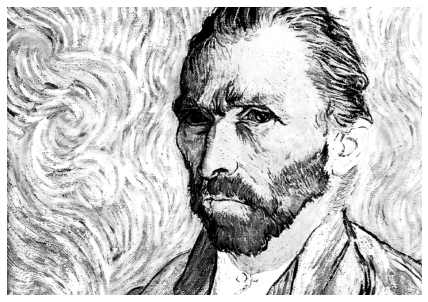

In [64]:


original_img = (io.imread(url))
image = pil_to_plt(original_img)


p2, p98 = np.percentile(image, (10,60))
image = exposure.rescale_intensity(image, in_range=(p2, p98))

image = rgb2gray(image)
bounding_box, density, points = density_region_points(image)

show_image(image)

Define functions to perform stippling operation

In [65]:
def bound_polygon(points, bounding_box):
    # idea from https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells
    i = np.logical_and(np.logical_and(bounding_box[0] <= points[:, 0], points[:, 0] <= bounding_box[1]), np.logical_and(bounding_box[2] <= points[:, 1], points[:, 1] <= bounding_box[3]))
    points_original = points[i, :]
    points_left = np.copy(points_original)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_original)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_original)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_original)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_original, np.append(np.append(points_left, points_right, axis=0), np.append(points_down, points_up, axis=0), axis=0), axis=0)
    return points, points_original

def voronoi_func(bounding_box, points):
    regions = []
    new_points, points_original = bound_polygon(points, bounding_box)
    voronoi = spatial.Voronoi(new_points)
    for region in voronoi.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = voronoi.vertices[index, 0]
                y = voronoi.vertices[index, 1]
                if not(bounding_box[0]-0.2 <= x <= bounding_box[1]+0.2 and
                       bounding_box[2]-0.2 <= y <= bounding_box[3]+0.2):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    voronoi.filtered_points = points_original
    voronoi.filtered_regions = regions
    return voronoi

def weighted_centroid(vertices, density):
    points = []
    for vertex in vertices:
        points.append((vertex[0], vertex[1]))
    polygon = MultiPoint(points)
    x_min = int(math.floor(polygon.bounds[1]))
    x_max = int(math.floor(polygon.bounds[3]))
    y_min = int(math.floor(polygon.bounds[0]))
    y_max = int(math.floor(polygon.bounds[2]))
    weight_sum = 0
    x_sum = 0
    y_sum = 0
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            if(polygon.contains(Point(x,y) or polygon.intersects(Point(x,y)))):
                x_sum += x*density[x][y]
                y_sum += y*density[x][y]
                weight_sum += density[x][y]

    if(weight_sum > 0):          
        x_centroid = x_sum / weight_sum
        y_centroid = y_sum / weight_sum
        return [x_centroid, y_centroid]
    else:
        return asarray(polygon.centroid)

def get_centroids(points, density):
    xmin, xmax = 0, density.shape[1]
    ymin, ymax = 0, density.shape[0]
    bounding_box = [xmin, xmax, ymin, ymax]
    voronoi_obj = voronoi_func(bounding_box, points)
    regions = voronoi_obj.filtered_regions
    centroids = []
    for region in regions:
        vertices = voronoi_obj.vertices[region, :]
        centroid = weighted_centroid(vertices, density)
        centroids.append(centroid)
    return regions, np.array(centroids), voronoi_obj

    
def stipple(points):
    x_min = bounding_box[0]
    x_max = bounding_box[1]
    y_min = bounding_box[2]
    y_max = bounding_box[3]
    ratio = (x_max-x_min)/(y_max-y_min)

    for i in range(iterations):
        regions, points, voronoi = get_centroids(points, density)

        fig = plt.figure(figsize=(15*ratio,15))
        ax = fig.add_axes([0, 0, 1, 1], frameon=False)
        ax.set_xlim([x_min, x_max])
        ax.set_xticks([])
        ax.set_ylim([y_min, y_max])
        ax.set_yticks([])
        scatter = ax.scatter(points[:, 0], points[:, 1], s=6, facecolor="k", edgecolor="None")
        plt.savefig(""+ str(num_samples) + "_"+ str(i) + ".png")
    return points, regions, ratio, voronoi

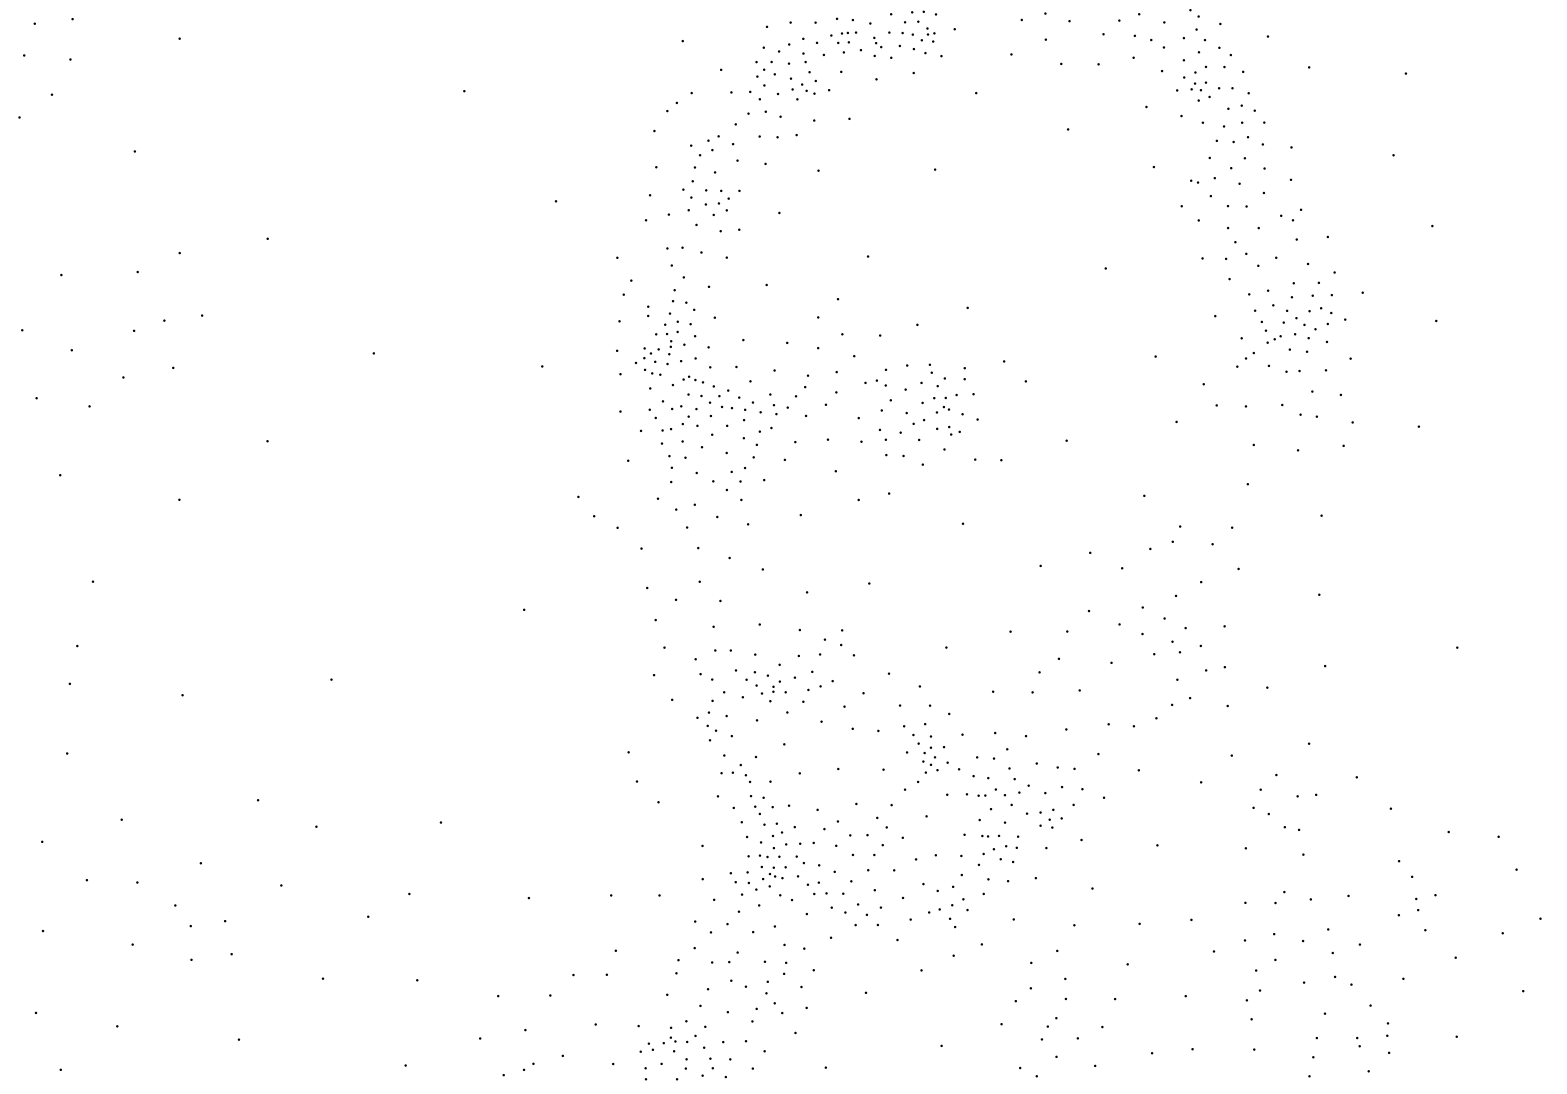

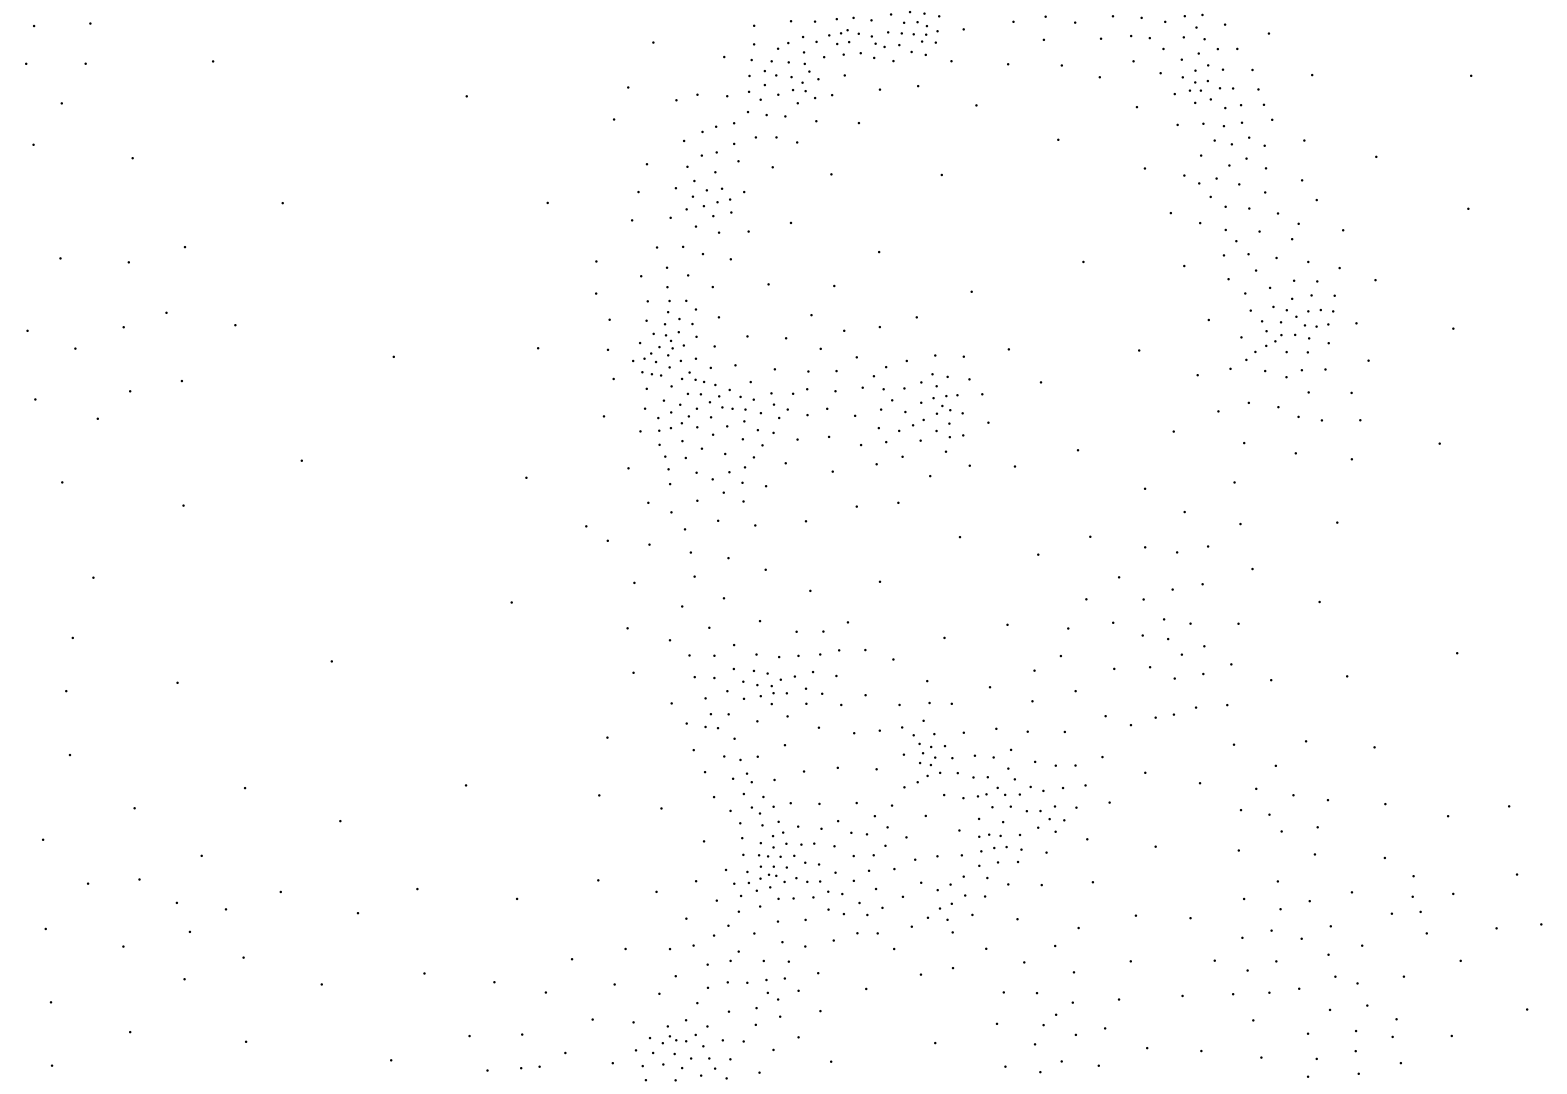

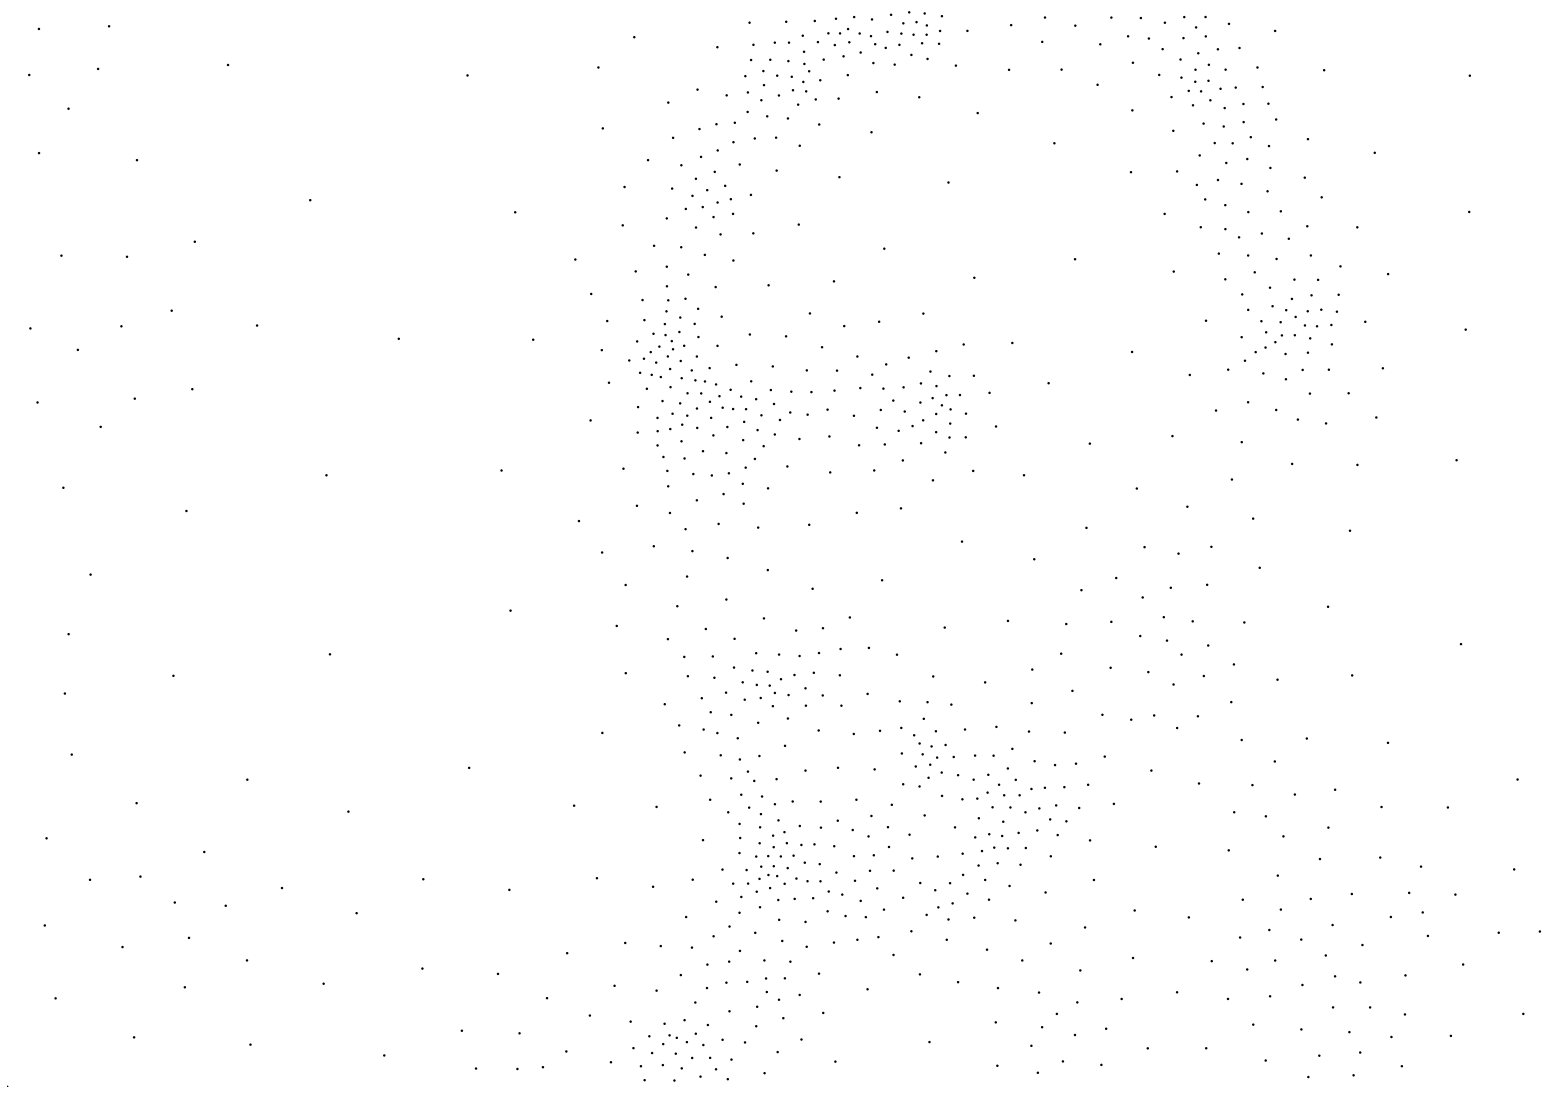

In [66]:
points, regions, ratio, voronoi = stipple(points)

In [20]:
def makeTSP(positions):
    size = positions.shape[0]
    distances = np.zeros((size,size))
    for i in range(size):
        for j in range(i+1,size):
            distances[i,j] = np.sqrt((positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2)
            distances[j,i] = distances[i,j]
    return distances

def greedy(distances):
    size_path = np.shape(distances)[0]
    dist = distances.copy()
    path_order = np.zeros(size_path)
    path_order[0] = int(np.random.randint(size_path))
    dist[:,int(path_order[0])] = np.Inf
    for i in range(size_path-1):
        path_order[i+1] = np.argmin(dist[int(path_order[i]),:])
        dist[:,int(path_order[i+1])] = np.Inf
    return path_order

def two_opt(d, path):
    path = np.array(path).astype(int)
    edges = np.stack([path[:-1], path[1:]])
    min_path_cost = np.sum(d[tuple(edges)])
    n = d.shape[0]
    while True:
        found_new = False
        for i in range(n - 1):
            print(i)
            for k in range(i + 2, n + 1):
                new_path = np.concatenate([path[:i], path[i:k][::-1], path[k:]])
                edges = np.stack([new_path[:-1], new_path[1:]])
                path_cost = np.sum(d[tuple(edges)])
                if path_cost < min_path_cost:
                    path = new_path
                    min_path_cost = path_cost
                    found_new = True
                    break
            if found_new:
                break
        if not found_new:
            break
    return path

In [ ]:
dx = np.subtract.outer(points[:,0], points[:,0])
dy = np.subtract.outer(points[:,1], points[:,1])
d = np.sqrt(dx ** 2 + dy ** 2).astype(int)

distances = makeTSP(points)
path = greedy(distances)
path = two_opt(d, path)


In [54]:
def plot(points, path, string):
    fig = plt.figure(figsize=(10*ratio,10))
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)
    ax.set_axis_off()
    plt.scatter(points[:,0],points[:,1], s=5, c="black")
    new_order = np.concatenate((np.array([points[int(path[i])] for i in range(len(path))]),np.array([points[0]])))
    plt.plot(new_order[:,0],new_order[:,1], c="black")
    plt.savefig(string+".png")
    plt.show()


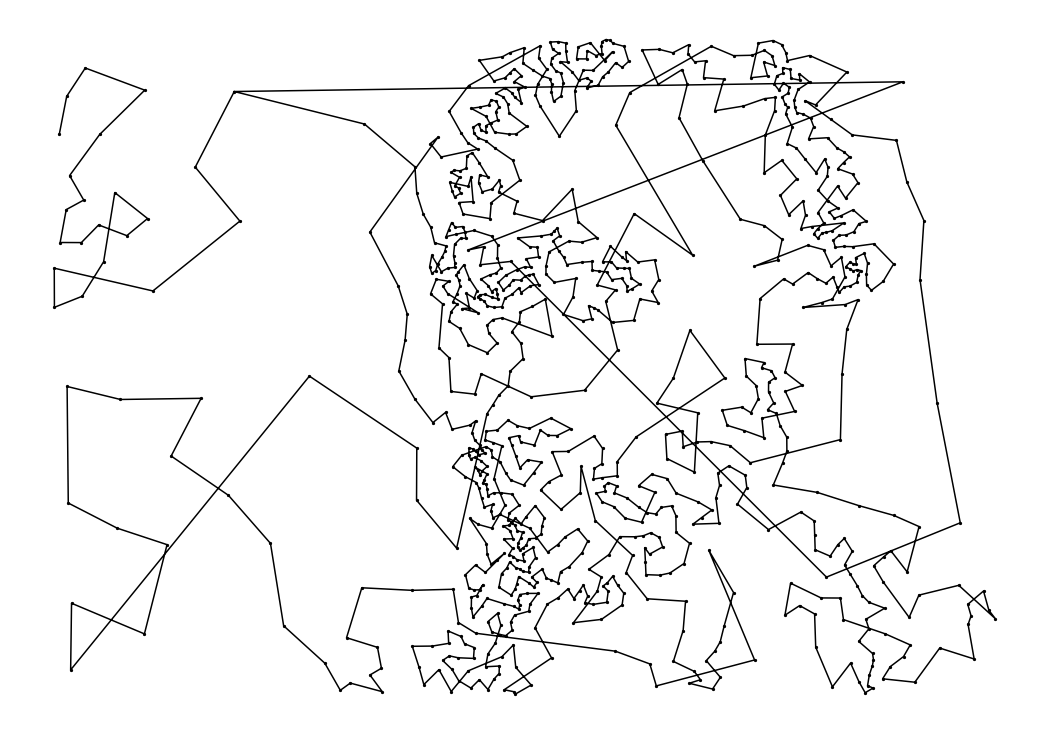

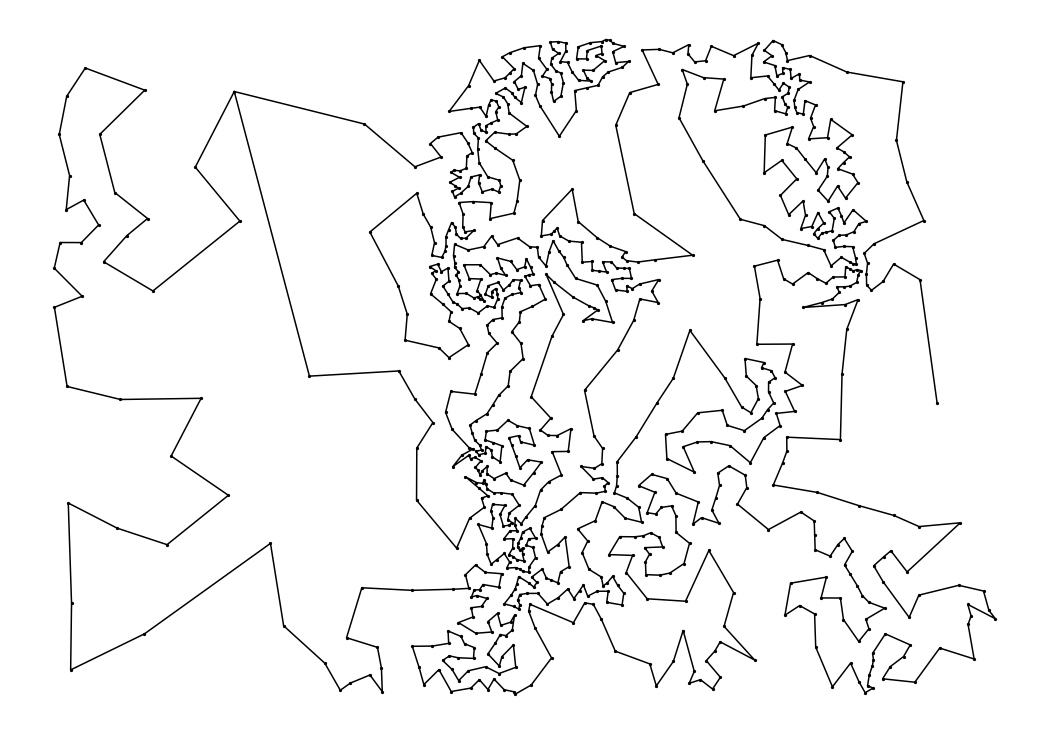

In [56]:
path_init = greedy(distances)
plot(points, path_init, "greedy")
plot(points, path, "opt")
